In [ ]:
'''
This is a super-fancy script to look at signal and noise correlations in A and Not A
Sessions in the visual behavior dataset. Everything is implemented to run in a speedy-quick way
thanks to Justin. Less credit goes to Yoni, but he is curating this particular bit of code.:
Created by Yoni Browning, Sept 2018

'''

In [47]:
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import scipy as sp
import numpy as np
import pandas as pd
# sometimes order maters on these
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import oBehave.plotting_stuff as obps
import oBehave.helperfunctions as obhf
import oBehave.neural_analysis as obna
import oBehave.behavior_analysis as obba
#from scipy import stats

from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
from visual_behavior.ophys.response_analysis.utilities import get_trace_around_timepoint,get_nearest_frame
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

experiment_id = 639438856# experiment B
#experiment_id = 639253368

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Load the manifest
manifest = obhf.load_manifest()
manifest= obba.includeNovelSession(manifest);
tmp_manifest = manifest[(manifest['first_session']==True)
                        &manifest.cre_line.str.contains('Slc')
                       &manifest.targeted_structure.str.contains('VISp') ]
tmp_manifest.reset_index(drop=True,inplace=True)

In [139]:
# Build a super dataframe that contains data from all cells, all sessions.
# This will speed things up later through pandas magic.
df = []
for ii, row in tmp_manifest.iterrows():
    dataset= VisualBehaviorOphysDataset(experiment_id=row.experiment_id, cache_dir=obhf.drive_path)
    analysis = ResponseAnalysis(dataset)
    fr = analysis.flash_response_df # Flash response Df 
    fb = obba.includeAddRepeats_dataset(dataset.stimulus_table,dataset.all_trials)# Flash/block data frame
    this_df = fr.merge(fb,left_on = ('flash_number','start_time','image_name'),
                     right_on = ('flash_number','start_time','image_name'),how= 'left')# overall data frame
    this_df['experiment_id'] = row.experiment_id
    this_df['session_type'] = row.session_type
    df.append(this_df)
df = pd.concat(df)

loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe
loading trial response dataframe
loading flash response dataframe


In [140]:
# make sure the last block returned something sensible
print(len(df))
df.head()

5758096


,cell,flash_number,start_time,image_name,mean_response,p_value,end_time,repeats,block,response_type,experiment_id,session_type
0,0,0,64.82974,im066,0.099607,0.005933,65.06301,1.0,1.0,None,652844352,behavior_session_A
1,0,1,65.56355,im066,0.119318,0.310219,65.81366,2.0,1.0,None,652844352,behavior_session_A
2,0,2,66.31410,im066,0.044861,0.067825,66.56425,3.0,1.0,None,652844352,behavior_session_A
3,0,3,67.06463,im066,-0.017527,0.302164,67.31488,4.0,1.0,None,652844352,behavior_session_A
4,0,4,67.81530,im066,-0.022459,0.790839,68.06550,5.0,1.0,None,652844352,behavior_session_A


In [141]:
# Compute mean responses and noise responses for each cell. 
# Note that the groupby('experiment_id') means that we only look at cells w/in one session at a time.
mean_responses = []
for experiment_id,experiment_df in df.groupby('experiment_id'):
    print(experiment_id)
    unique_cells = experiment_df.cell.unique()
    unique_images =  experiment_df.image_name.unique()

    # compute mean respsonces
    for c1 in unique_cells:
        c1_im_means = np.zeros(unique_images.shape)
        for ii,image in enumerate(unique_images):
            mean_responses.append(
                dict(
                    experiment_id=experiment_id,
                    session_type = experiment_df.session_type.iloc[0],
                    cell=c1,
                    image_name=image,
                    mean=experiment_df[(experiment_df['image_name']==image)
                                       &( experiment_df['cell']==c1)].mean_response.mean(),
                )
            )

mean_responses = pd.DataFrame(mean_responses)
# make a table of per-cell responces, aranged w/ images in columns.

cell_responses = mean_responses.pivot_table(
    index=['experiment_id','session_type','cell'],
    columns='image_name',
    values='mean',
)

noise_df = df.merge(mean_responses,on = ['experiment_id','session_type','cell','image_name'])
noise_df.mean_response = noise_df.mean_response-noise_df['mean']
noise_df.drop('mean',axis = 1,inplace = True)
noise_df.rename(index = str,columns = {'mean_response':'noise_response'},inplace = True)
noise_responses = noise_df.pivot_table(
    index=['experiment_id','session_type','cell'],
    columns='flash_number',
    values='noise_response',
)

639253368
639438856
639769395
639932228
652844352
653053906
653123781
670396087
671152642
672185644
672584839
685744008
686726085


In [160]:
cell_responses.head()

image_name                             im000  im005  im012  im013  im024  \
experiment_id session_type       cell                                      
639253368     behavior_session_A 0       NaN    NaN    NaN    NaN    NaN   
                                 1       NaN    NaN    NaN    NaN    NaN   
                                 2       NaN    NaN    NaN    NaN    NaN   
                                 3       NaN    NaN    NaN    NaN    NaN   
                                 4       NaN    NaN    NaN    NaN    NaN   

image_name                             im031  im034  im035  im036  im044  \
experiment_id session_type       cell                                      
639253368     behavior_session_A 0       NaN    NaN    NaN    NaN    NaN   
                                 1       NaN    NaN    NaN    NaN    NaN   
                                 2       NaN    NaN    NaN    NaN    NaN   
                                 3       NaN    NaN    NaN    NaN    NaN   
                                 4       NaN    NaN    NaN    NaN    NaN   

image_name                             ...    im075     im077  im078  \
experiment_id session_type       cell  ...                             
639253368     behavior_session_A 0     ...      NaN  0.018667    NaN   
                                 1     ...      NaN  0.030187    NaN   
                                 2     ...      NaN  0.009014    NaN   
                                 3     ...      NaN  0.009802    NaN   
                                 4     ...      NaN  0.010928    NaN   

image_name                                im085  im087  im091  im104  im106  \
experiment_id session_type       cell                                         
639253368     behavior_session_A 0     0.010022    NaN    NaN    NaN    NaN   
                                 1     0.007871    NaN    NaN    NaN    NaN   
                                 2     0.012984    NaN    NaN    NaN    NaN   
                                 3     0.004665    NaN    NaN    NaN    NaN   
                                 4     0.008932    NaN    NaN    NaN    NaN   

image_name                             im114  im115  
experiment_id session_type       cell                
639253368     behavior_session_A 0       NaN    NaN  
                                 1       NaN    NaN  
                                 2       NaN    NaN  
                                 3       NaN    NaN  
                                 4       NaN    NaN  

[5 rows x 32 columns]

In [164]:
# compute signal correlations
corr_data = []
for row1,row2 in itertools.combinations(cell_responses.iterrows(),2):
    (exp1,beh1,c1), c1_data = row1
    (exp2,_,c2), c2_data = row2
    # Don't compare data from different experiments!!!!!
    if (exp1 == exp2):
        # compute the signal correlation
        try:
            scorr = sp.stats.pearsonr(c1_data[~np.isnan(c1_data)],c2_data[~np.isnan(c2_data)])[0]
        except ValueError:
            scorr = np.nan
        # compute the noise correlation    
        corr_data.append(
            dict(
                experiment_id = exp1,
                session_type = beh1,
                cell1 = c1,
                cell2 = c2,
                corr = scorr,
                corr_type = 'signal',
            )
        )
    
    
# Compute noise correlations
for row1,row2 in itertools.combinations(noise_responses.iterrows(),2):
    (exp1,beh1,c1), c1_data = row1
    (exp2,_,c2), c2_data = row2
    # Don't compare data from different experiments!!!!!
    if (exp1 == exp2): 
        # compute the signal correlation
        try:
            ncorr = sp.stats.pearsonr(c1_data[~np.isnan(c1_data)],c2_data[~np.isnan(c2_data)])[0]
        except ValueError:
            ncorr = np.nan
        # compute the noise correlation    
        corr_data.append(
            dict(
                experiment_id = exp1,
                session_type = beh1,
                cell1 = c1,
                cell2 = c2,
                corr = ncorr,
                corr_type = 'noise'
            )
        )



In [166]:
# reshape the data into a useable table.
CD = pd.DataFrame(corr_data)
corr_table = CD.pivot_table(
    index = ['experiment_id','session_type','cell1','cell2'],
    columns = 'corr_type',
    values = 'corr',
).reset_index()

In [167]:
# make sure pivot worked.
corr_table.head()

corr_type,experiment_id,session_type,cell1,cell2,noise,signal
0,639253368,behavior_session_A,0,1,0.055220,0.446361
1,639253368,behavior_session_A,0,2,0.199815,0.822796
2,639253368,behavior_session_A,0,3,0.150812,0.651764
3,639253368,behavior_session_A,0,4,0.207394,0.911265
4,639253368,behavior_session_A,0,5,0.087318,0.383101


In [210]:
# simple plotting, as a sanity check
import seaborn as sns
tmp_corr_table = corr_table.copy()
#tmp_corr_table.iloc([tmp_corr_table.session_type.str.contains('A')]).session_type = 'not_A'
sns.lmplot('signal', 'noise', data=tmp_corr_table,
           #col='session_type',
           hue='session_type',
          )

TypeError: unhashable type: 'list'

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is dep

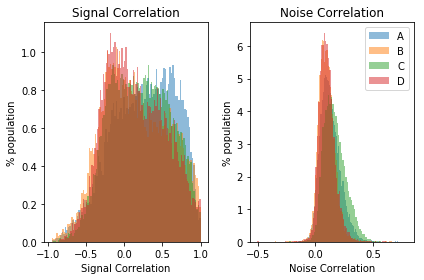

In [208]:
# plot histograms
fig = plt.figure()
ax = fig.subplots(1,2)
s_a = corr_table.signal[corr_table.session_type.str.contains('A')].values
ax[0].hist(s_a[~np.isnan(s_a)],100,alpha = .5,normed= True);
s_na = corr_table.signal[corr_table.session_type.str.contains('B')].values
ax[0].hist(s_na[~np.isnan(s_na)],100,alpha = .5,normed = True);
s_na = corr_table.signal[corr_table.session_type.str.contains('C')].values
ax[0].hist(s_na[~np.isnan(s_na)],100,alpha = .5,normed = True);
s_na = corr_table.signal[corr_table.session_type.str.contains('D')].values
ax[0].hist(s_na[~np.isnan(s_na)],100,alpha = .5,normed = True);
ax[0].set_xlabel('Signal Correlation')
ax[0].set_ylabel('% population')
ax[0].set_title('Signal Correlation')
#ax[0].legend(['A','not A'])

n_a = corr_table.noise[corr_table.session_type.str.contains('A')].values
ax[1].hist(n_a[~np.isnan(n_a)],100,alpha = .5,normed= True);
n_na = corr_table.noise[corr_table.session_type.str.contains('B')].values
ax[1].hist(n_na[~np.isnan(n_na)],100,alpha = .5,normed = True);
n_na = corr_table.noise[corr_table.session_type.str.contains('C')].values
ax[1].hist(n_na[~np.isnan(n_na)],100,alpha = .5,normed = True);
n_na = corr_table.noise[corr_table.session_type.str.contains('D')].values
ax[1].hist(n_na[~np.isnan(n_na)],100,alpha = .5,normed = True);
ax[1].set_xlabel('Noise Correlation')
ax[1].set_ylabel('% population')
ax[1].set_ylabel('% population')
ax[1].set_title('Noise Correlation')
ax[1].legend(['A','B','C','D'])
fig.tight_layout()


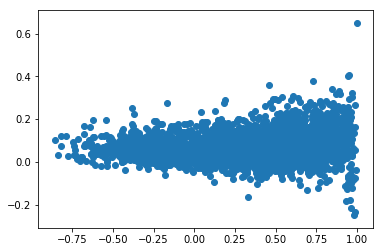

In [81]:
# visualize scatter...just a sanity check, graph is ugly
plt.scatter(corr_table.signal.values,corr_table.noise.values)

In [38]:
cell_responses = mean_responses.pivot_table(
    index=['experiment_id','cell'],
    columns='image_name',
    values='mean',
)

In [218]:
# KS test to see if distributions are different
sp.stats.ks_2samp(corr_table.noise[corr_table.session_type.str.contains('A')].values,
                corr_table.noise[~corr_table.session_type.str.contains('A')].values)


Ks_2sampResult(statistic=0.030679495704596493, pvalue=1.3885448956431168e-10)

/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label'
  s)
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been

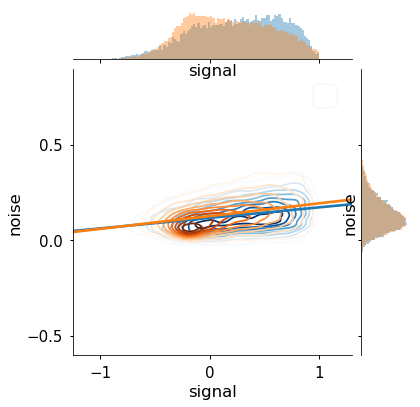

In [238]:
# Fancier version of the plot above, showing things in 2d
import matplotlib.pyplot as plt
import seaborn as sns
colorlist = plt.rcParams['axes.prop_cycle'].by_key()['color']


nonan_corr_table = corr_table[(np.isfinite(corr_table.signal))&(np.isfinite(corr_table.noise))]
is_A = nonan_corr_table[nonan_corr_table.session_type.str.contains('A')]
not_A = nonan_corr_table[~nonan_corr_table.session_type.str.contains('A') ]

g = sns.JointGrid(x="signal", y="noise", data=corr_table)
sns.set_context("notebook", font_scale=3)
sns.kdeplot(is_A.signal, is_A.noise, cmap="Blues",
            shade=False, shade_lowest=True, ax=g.ax_joint,label = 'A')
sns.kdeplot(not_A.signal, not_A.noise, cmap="Oranges",
            shade=False, shade_lowest=True, ax=g.ax_joint,label = 'Not A')
g.ax_joint.legend()
sns.distplot(is_A.signal, kde=False, color=colorlist[0],bins=100, ax=g.ax_marg_x,norm_hist = True)
sns.distplot(not_A.signal, kde=False, color=colorlist[1],bins=100, ax=g.ax_marg_x,norm_hist = True)
sns.regplot(x="signal", y="noise", data=is_A,color=colorlist[0],scatter = False,ci = False,ax=g.ax_joint)
sns.regplot(x="signal", y="noise", data=not_A,color=colorlist[1],scatter = False,ci = False,ax=g.ax_joint)
sns.distplot(is_A.noise, kde=False, color=colorlist[0],bins=100, ax=g.ax_marg_y, vertical=True,norm_hist = True)
sns.distplot(not_A.noise, kde=False, color=colorlist[1],bins=100, ax=g.ax_marg_y, vertical=True,norm_hist = True)
plt.show()

In [ ]:
# Old version...see above for a better one!!

# unique_cells = fr.cell.unique()
# unique_images =  fb.image_name.unique()

# mean_responses = []
# # compute mean respsonces
# for c1 in unique_cells:
#     c1_im_means = np.zeros(unique_images.shape)
#     for ii,image in enumerate(unique_images):
#         mean_responses.append(
#             dict(
#                 experiment_id=experiment_id,
#                 cell=c1,
#                 image_name=image,
#                 mean=df[(df['image_name']==image)&( df['cell']==c1)].mean_response.mean(),
#             )
#         )
        
# mean_responses = pd.DataFrame(mean_responses)
# # make a table of per-cell responces, aranged w/ images in columns.

# cell_responses = mean_responses.pivot_table(
#     index=['experiment_id','cell'],
#     columns='image_name',
#     values='mean',
# )

# noise_df = df.merge(mean_responses,on = ['cell','image_name'])
# noise_df.mean_response = noise_df.mean_response-noise_df['mean']
# noise_df.drop('mean',axis = 1,inplace = True)
# noise_df.rename(index = str,columns = {'mean_response':'noise_response'},inplace = True)
# noise_responses = noise_df.pivot_table(
#     index=['experiment_id','cell'],
#     columns='flash_number',
#     values='noise_response',
# )


# noise_df = df.merge(mean_responses,on = ['cell','image_name'])
# noise_df.mean_response = noise_df.mean_response-noise_df['mean']
# noise_df.drop('mean',axis = 1,inplace = True)
# noise_df.rename(index = str,columns = {'mean_response':'noise_response'},inplace = True)
# noise_responses = noise_df.pivot_table(
#     index=['experiment_id','cell'],
#     columns='flash_number',
#     values='noise_response',
# )

In [ ]:
# Another Old version...dont run this
# for c2 in unique_cells:
#         c2_im_means = [df[(df['image_name']==image)&( df['cell']==c2)].mean_response.mean() for image in unique_images]
        
            
# for c1 in unique_cells:
#     for c2 in unique_cells:
#         # make sure we haven't done this already
#         if (not c1==c2) and (not ((c1 in rdict['cell2']) and (c2 in rdict['cell1']))):
#             # Start
#             rdict['experiment_id'].append('experiment_id')
#             rdict['cell1'].append(c1)
#             rdict['cell2'].append(c2)
#             # Signal Correlation
#             c1_im_means = [df[(df['image_name']==image)&( df['cell']==c1)].mean_response.mean() for image in unique_images]
#             c2_im_means = [df[(df['image_name']==image)&( df['cell']==c2)].mean_response.mean() for image in unique_images]
#             s_corr = np.corrcoef(c1_im_means,c2_im_means)[0,1]
#             rdict['SCorrAll'].append(s_corr)
#             # Noise Correlation
#             c1_responses = df[df.cell==c1].sort_values('flash_number',inplace = False).mean_response.values 
#             c2_responses = df[df.cell==c2].sort_values('flash_number',inplace = False).mean_response.values 
#             n_corr = np.corrcoef(c1_responses,c2_responses)[0,1]
#             rdict['NCorrAll'].append(n_corr)
#             print(str(c1) +' '+str(c2))